<html> <h1 style="font-style:bold; color:blue;"> Machine Learning in Finance </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-5 </h1> </html>

#### More Advanced Trading Practices

## Forex EUR/USD price forecasting

#### It is a training example of forecasting the EUR/USD Forex next-tick prices

#### ONE-DIMENSIONAL Convolutional Neural Network was used
#### Tick Data with Dukascopy Bank (https://www.dukascopy.com/swiss/english/marketwatch/historical/)

#### !! Please note, that this notebook is a hands-on tutorial on Keras. Actual predicting stock and Forex prices is a really challenging and complex task that requires tremendous effort, especially at higher frequencies, such as ticks used in this practical

#### The Aim: According to the dynamics of TICK PRICES and VOLUME Forex EUR/USD to forecast the price of the next tick
#### We use a substantially refined and ALREADY normalised *.csv file based on raw data from the Dukastcopy repository.

#### Price, volume, and the time intervals between ticks have been normalised previously because this process requires significant computational time.
#### Price normalisation principles: subtract the minimum and divide by the maximum price among 50 ticks that include this tick. 
#### Normalisation of volumes: based on a maximum of 10 lots (the main number of lots). The volume of more than 10  lots is equated to 10 lots (those to 1 after normalisation).
##### We normalised intervals between ticks: based on a maximum of 20,000 milliseconds (20 seconds) (the main number of intervals). The interval of over 20 seconds is equated to 20 seconds (those to 1 after normalisation).


______________________________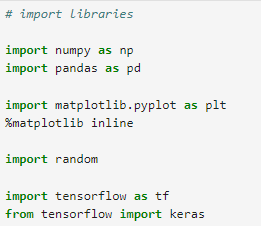

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random

import tensorflow as tf
from tensorflow import keras

____________________________

In [2]:
print(tf.__version__)

2.20.0


_________________________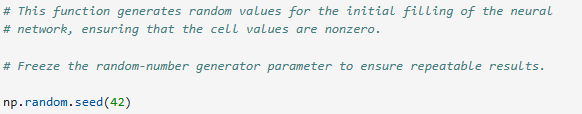

In [3]:
np.random.seed(42)

### Data 
#### We use a substantially refined and ALREADY normalised *.csv file based on raw data from the Dukascopy repository.

_____________________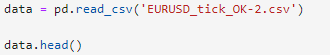

In [4]:
data = pd.read_csv('EURUSD_tick_OK-2.csv')

data.head()

,Vol_Ask_N,Ask_N_200_3,DateDelta1_N,Bid_N_200_3,Vol_Bid_N
0,0.176,0.636364,0.01655,0.515152,0.100
1,0.364,0.606061,0.02750,0.454545,0.420
2,0.100,0.575758,0.09770,0.454545,0.187
3,0.100,0.151515,0.01590,0.121212,0.100
4,0.270,0.212121,0.01040,0.060606,0.214


____________________

In [5]:
data.tail()

,Vol_Ask_N,Ask_N_200_3,DateDelta1_N,Bid_N_200_3,Vol_Bid_N
1099995,0.100,0.705357,0.01060,0.687500,0.195
1099996,0.100,0.758929,0.01630,0.741071,0.244
1099997,0.100,0.776786,0.00260,0.750000,0.382
1099998,0.461,0.794643,0.01045,0.758929,0.393
1099999,0.536,0.794643,0.00260,0.758929,0.664


_________________________________________

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vol_Ask_N     1100000 non-null  float64
 1   Ask_N_200_3   1100000 non-null  float64
 2   DateDelta1_N  1100000 non-null  float64
 3   Bid_N_200_3   1100000 non-null  float64
 4   Vol_Bid_N     1100000 non-null  float64
dtypes: float64(5)
memory usage: 42.0 MB


In [7]:
# This dataset has already been normalised inside 50 tick windows and prepared for training.
# The data consists of normalised Ask prices (offers) and Bid prices (demands), along 
# with the corresponding transaction Volumes at the Ask and Bid prices.
# A sequence of time intervals between adjacent ticks has been added as a parameter, 
# which contains critical information about the behaviour of market participants, such as buyers and sellers.

____________________________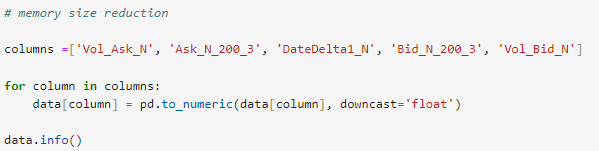

In [8]:
columns = ['Vol_Ask_N', 'Ask_N_200_3', 'DateDelta1_N', 'Bid_N_200_3', 'Vol_Bid_N']

for column in columns:
    data[column] = pd.to_numeric(data[column], downcast='float')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vol_Ask_N     1100000 non-null  float32
 1   Ask_N_200_3   1100000 non-null  float32
 2   DateDelta1_N  1100000 non-null  float32
 3   Bid_N_200_3   1100000 non-null  float32
 4   Vol_Bid_N     1100000 non-null  float32
dtypes: float32(5)
memory usage: 21.0 MB


_____________________________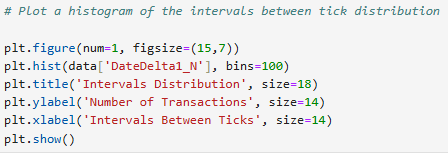

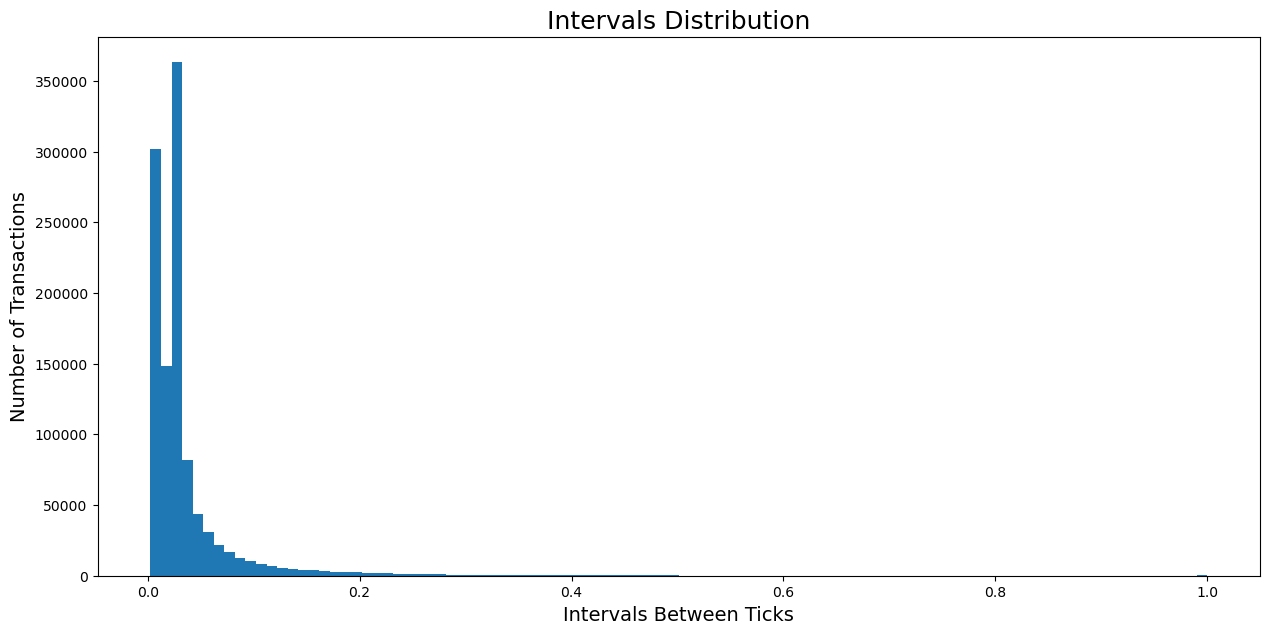

In [9]:
plt.figure(num=1, figsize=(15,7))
plt.hist(data['DateDelta1_N'], bins=100)
plt.title('Intervals Distribution', size=18)
plt.ylabel('Number of Transactions', size=14)
plt.xlabel('Intervals Between Ticks', size=14)
plt.show()

In [10]:
# Explain the above distribution by writing a couple of sentences.

In [11]:
It is a plot of the requests to buy shares against the amount of shares included in each request. 
On average it shows that requests around 0.1 are most common, but there are large random distributions in the drop off afterwards.
Additionally, it shows that almost no requests are to buy less than 0.1.

SyntaxError: invalid syntax (617034157.py, line 1)

___________________________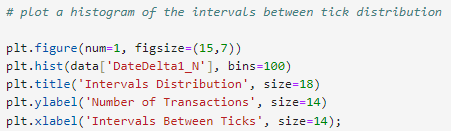

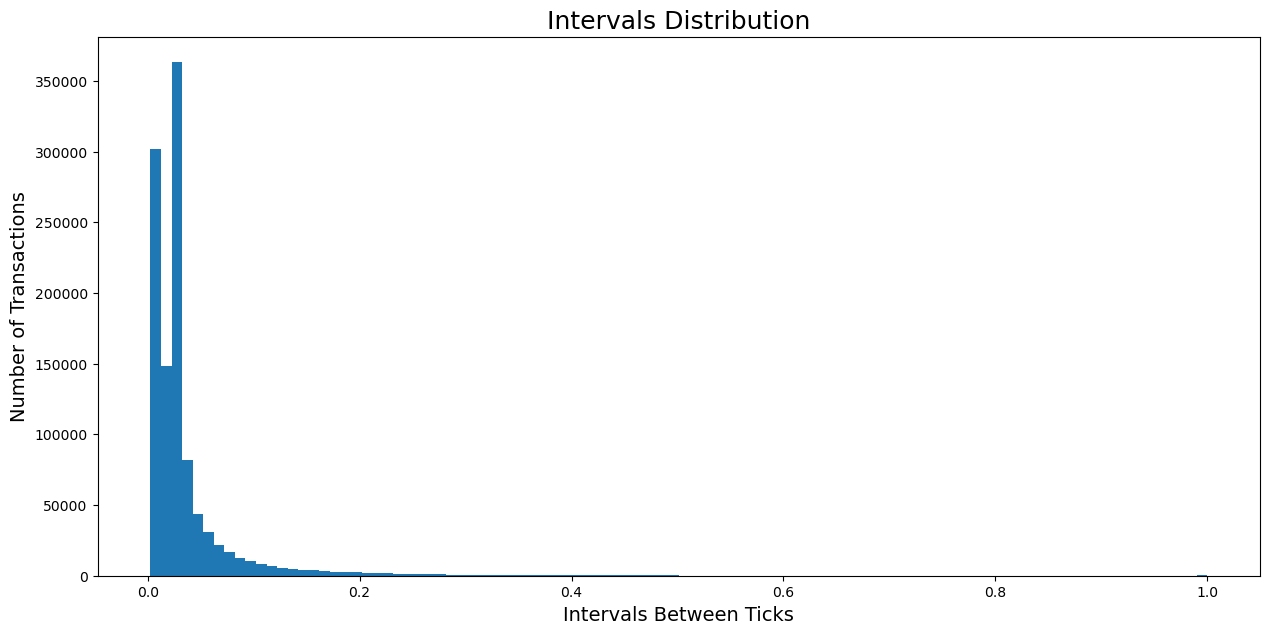

In [12]:
plt.figure(num=1, figsize=(15,7))
plt.hist(data['DateDelta1_N'], bins=100)
plt.title('Intervals Distribution', size=18)
plt.ylabel('Number of Transactions', size=14)
plt.xlabel('Intervals Between Ticks', size=14)
plt.show()

In [ ]:
# Explain the above distribution by writing a couple of sentences.

In [ ]:
It is a depiction of the delay for purchasing stocks. 
This distribution shows that it is most common for shares to take very little time to process, with a smooth drop-off as time increases.

##### Create NumPy 

In [13]:
# We will analyse only part of the dataset, as training the neural network on 
# the entire dataset would require massive computational power.

# n_small = 250,000 ticks, which equals around 1 week.

# We will create a three-dimensional data tensor: [(n_small-N + 1), N, 5] and 
# a two-dimensional array of answers [(n_small-N + 1), N] with a tick price-shifted one tick up.

# N=50 is the number of ticks analysed at each step; they look backwards from the current moment.

# Then, you must delete the last sliced square subarray (50*5) since there is no price for the subsequent tick.

# Summary: the intermediate aim is to create
# 1. three-dimensional data tensor of sliced square subarrays [(n_small - N + 1 - 1), N, 5] and
# 2. two-dimensional array of answers Y[(n_small - N + 1 - 1), N] with a tick price shifted one tick up.

______________________________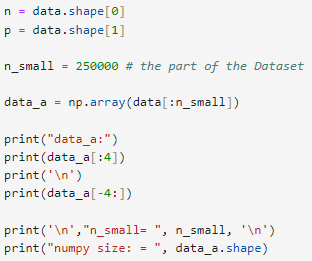

In [14]:
n = data.shape[0]
p = data.shape[1]

n_small = 250000
data_a = np.array(data[:n_small])

print("data_a:")
print(data_a[:4])
print('\n')
print(data_a[-4:])

print('\n', "n_small= ", n_small, '\n')
print("numpy size: = ", data_a.shape)

data_a:
[[0.176      0.6363636  0.01655    0.5151515  0.1       ]
 [0.364      0.6060606  0.0275     0.45454547 0.42      ]
 [0.1        0.57575756 0.0977     0.45454547 0.187     ]
 [0.1        0.15151516 0.0159     0.12121212 0.1       ]]


[[0.45       0.53424656 0.01085    0.46575344 0.345     ]
 [0.1        0.5068493  0.028      0.46575344 0.195     ]
 [0.1        0.5068493  0.0377     0.47945204 0.1       ]
 [0.1        0.5068493  0.03505    0.46575344 0.12      ]]

 n_small=  250000 

numpy size: =  (250000, 5)


____________________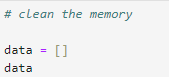

In [15]:
data = []
data

[]

##### Final aim: predicting the Bid and Ask prices of the next tick in FOREX EURUSD. 

_________________________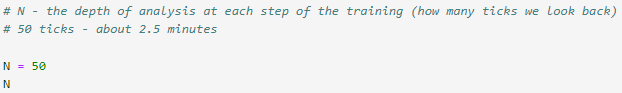

In [16]:
N = 50
n

1100000

________________________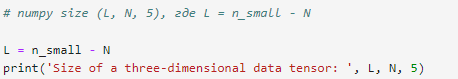

In [17]:
L = n_small - N
print('Size of a three-dimensional data tensor: ', L, N, 5)

Size of a three-dimensional data tensor:  249950 50 5


In [ ]:
# create zeros tensors with 'float32' (not 'float64') for reducing calculations

_____________________________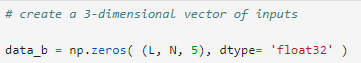

In [18]:
data_b = np.zeros( (L, N, 5), dtype= 'float32' )

____________________________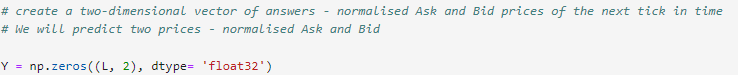

In [19]:
Y = np.zeros((L, 2), dtype= 'float32')

__________________________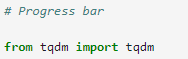

In [20]:
from tqdm import tqdm

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [21]:
# fill the array for training data_b and the array of answers Y from the original data_a array

print('n_small - N = ', n_small-N)
for k in tqdm(range(n_small-N)):
    data_b[k, :, :] = data_a[k:k+N, :]   
                                          
    Y[k,0] = data_a[k+N,3]   # normalised bid - value for one tick to the future
    Y[k,1] = data_a[k+N,1]   # normalised Ask - value for one tick to the future 
print(k) # print index value (for control)
    
print('data_b:', '\n', data_b)
print("Numpy size:        ", data_b.shape, '\n')

print( Y[:5,:])
print( Y[-10:,:])
print(      "Numpy size:         ", Y.shape)

n_small - N =  249950


100%|██████████| 249950/249950 [00:00<00:00, 530766.77it/s]

249949
data_b: 
 [[[0.176      0.6363636  0.01655    0.5151515  0.1       ]
  [0.364      0.6060606  0.0275     0.45454547 0.42      ]
  [0.1        0.57575756 0.0977     0.45454547 0.187     ]
  ...
  [0.232      0.45454547 0.2092     0.36363637 0.11      ]
  [0.1        0.42424244 0.2085     0.36363637 0.12      ]
  [0.102      0.45454547 0.0284     0.36363637 0.232     ]]

 [[0.364      0.6060606  0.0275     0.45454547 0.42      ]
  [0.1        0.57575756 0.0977     0.45454547 0.187     ]
  [0.1        0.15151516 0.0159     0.12121212 0.1       ]
  ...
  [0.1        0.42424244 0.2085     0.36363637 0.12      ]
  [0.102      0.45454547 0.0284     0.36363637 0.232     ]
  [0.125      0.45454547 0.2103     0.3939394  0.11      ]]

 [[0.1        0.57575756 0.0977     0.45454547 0.187     ]
  [0.1        0.15151516 0.0159     0.12121212 0.1       ]
  [0.27       0.21212122 0.0104     0.06060606 0.214     ]
  ...
  [0.102      0.45454547 0.0284     0.36363637 0.232     ]
  [0.125      0.4

______________________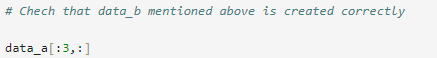

In [22]:
data_a[:3,:]

array([[0.176     , 0.6363636 , 0.01655   , 0.5151515 , 0.1       ],
       [0.364     , 0.6060606 , 0.0275    , 0.45454547, 0.42      ],
       [0.1       , 0.57575756, 0.0977    , 0.45454547, 0.187     ]],
      dtype=float32)

__________________________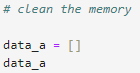

In [23]:
data_a = []
data_a

[]

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [24]:
# Control of the correctness of filling the array Y 
# (should show the normalised prices Bid and Ask one step ahead)

pp = random.randint(10, n_small-N-1)    # (any number before 249949) - just to look at the middle of data_b
print('random int = ', pp)

print('\t','data_b:', '\t\t\\t\t\t','Y:')
print('Bid ','\t\t\t','Ask', '\t\t\t','Bid','\t\t\t','Ask')

for i in range(7):
    print(data_b[pp+i,N-1,3], '\t\t', data_b[pp+i,N-1,1], '\t\t', Y[pp+i,0], '\t\t', Y[pp+i,1])

random int =  180542
	 data_b: 		\t		 Y:
Bid  			 Ask 			 Bid 			 Ask
0.054945055 		 0.0989011 		 0.07692308 		 0.10989011
0.07692308 		 0.10989011 		 0.07692308 		 0.13186814
0.07692308 		 0.13186814 		 0.08791209 		 0.13186814
0.08791209 		 0.13186814 		 0.08791209 		 0.10989011
0.08791209 		 0.10989011 		 0.08791209 		 0.12087912
0.08791209 		 0.12087912 		 0.07692308 		 0.0989011
0.07692308 		 0.0989011 		 0.010989011 		 0.032967035


In [ ]:
# Each row of Y above must have prices of one tick to the future.
# You can run the previous cell several times to ensure the array Y is filled out correctly

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [25]:
# We print Min and Max of all normalised columns - All should be in the range [0; 1]
# Check that the matrixes are normalised and there are no values > 1

print('\t','\t Max \t\t Min')
mmx  = data_b[:,:,0].max()
mmn  = data_b[:,:,0].min()
print('Vol_Ask_N', '\t', mmx, '\t\t', mmn)
mmx  = data_b[:,:,1].max()
mmn  = data_b[:,:,1].min()
print('Ask_N_use', '\t', mmx, '\t\t', mmn)
mmx  = data_b[:,:,2].max()
mmn  = data_b[:,:,2].min()
print('DateDelta1_N', '\t', mmx, '\t\t', mmn)
mmx  = data_b[:,:,3].max()
mmn  = data_b[:,:,3].min()
print('Bid_N_use', '\t', mmx, '\t', mmn)
mmx  = data_b[:,:,4].max()
mmn  = data_b[:,:,4].min()
print('Vol_Bid_N', '\t', mmx, '\t\t', mmn)

	 	 Max 		 Min
Vol_Ask_N 	 1.0 		 0.01
Ask_N_use 	 1.0 		 0.004484305
DateDelta1_N 	 1.0 		 0.0025
Bid_N_use 	 0.995283 	 0.0
Vol_Bid_N 	 1.0 		 0.01


### Data for training and testing

________________________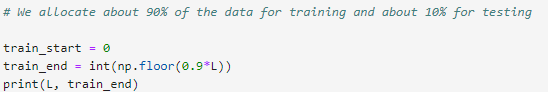

In [26]:
train_start = 0
train_end = int(np.floor(0.9*L))
print(L, train_end)

249950 224955


_____________________________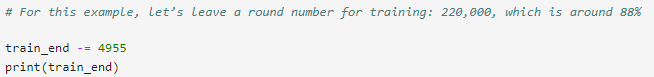

In [27]:
train_end -= 4955
print(train_end)

220000


_________________________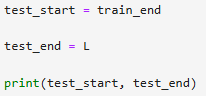

In [28]:
test_start = train_end
test_end = L
print(test_start, test_end)

220000 249950


_______________

In [ ]:
print(test_end-train_end)

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [29]:
# form X_train and X_test
# Divide data_b into two unequal parts: for training (X_train) and for test (X_test)

X_train = np.zeros( ( trainDataLength, N, 5) , dtype= 'float32')
X_test  = np.zeros( ( test_end-train_end, N, 5) , dtype= 'float32')

for z in tqdm(range(test_end)):
    if z < train_end:
        X_train[z,:,:] = data_b[z,:,:]
    else:
        X_test[z-train_end,:,:]  = data_b[z,:,:]    


print("X_train: ", X_train.shape, '\n')
print("X_test:  ", X_test.shape, '\n')

100%|██████████| 249950/249950 [00:00<00:00, 754966.63it/s]

X_train:  (220000, 50, 5) 

X_test:   (29950, 50, 5) 



_______________________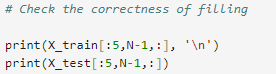

In [30]:
print(X_train[:5, N-1, :], '\n')
print(X_test[:5, N-1:])

[[0.102      0.45454547 0.0284     0.36363637 0.232     ]
 [0.125      0.45454547 0.2103     0.3939394  0.11      ]
 [0.1        0.45454547 0.02625    0.3939394  0.382     ]
 [0.27       0.4848485  0.0358     0.3939394  0.27      ]
 [0.262      0.4848485  0.04245    0.45454547 0.1       ]] 

[[[0.145      0.76623374 0.03765    0.74025977 0.1       ]]

 [[0.12       0.76623374 0.0285     0.74025977 0.1       ]]

 [[0.107      0.76623374 0.02745    0.74025977 0.1       ]]

 [[0.12       0.76623374 0.069      0.71428573 0.525     ]]

 [[0.145      0.76623374 0.1029     0.74025977 0.1       ]]]


#### Create the answer matrixes (outputs) for the training (y_train) and testing (y_test) 

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [31]:
y_train = Y[np.arange(train_start, train_end), :]
y_test = Y[np.arange(test_start,L-1), :]
print(train_start, train_end-1, '\n')

print('y_train(first 6):', '\n', y_train[:6,:], '\n')

data_add_row = np.array([y_test[L-test_start-2,0], y_test[L-test_start-2,1]])  # price adding

y_test = np.vstack([y_test, data_add_row])       # vstack - union of arrays
print(test_start, L, '\n')

print('y_test(last 6 ):', '\n', y_test[-6:,:])

0 219999 

y_train(first 6): 
 [[0.3939394  0.45454547]
 [0.3939394  0.45454547]
 [0.3939394  0.4848485 ]
 [0.45454547 0.4848485 ]
 [0.5151515  0.54545456]
 [0.5151515  0.6060606 ]] 

220000 249950 

y_test(last 6 ): 
 [[0.5479452  0.60273975]
 [0.53424656 0.5753425 ]
 [0.46575344 0.53424656]
 [0.46575344 0.5068493 ]
 [0.47945204 0.5068493 ]
 [0.47945204 0.5068493 ]]


#### Final control

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [32]:
# print X_train, y_train, X_test и y_test

print('Data for training:')
print("X_train:")
print("Type: ", X_train.dtype,  type(X_train), "; Size: ", X_train.shape)

print("\n","y_train:")
print("Type: ", y_train.dtype,  type(y_train), "; Size: ", y_train.shape)

print('Data for testing:')
print("\n","X_test:")
print("Type: ", X_test.dtype, type(X_test), "; Size: ", X_test.shape)

print("\n","y_test:")
print("Type: ", y_test.dtype,  type(y_test), "; Size: ", y_test.shape)

Data for training:
X_train:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (220000, 50, 5)

 y_train:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (220000, 2)
Data for testing:

 X_test:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (29950, 50, 5)

 y_test:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (29950, 2)


### Convolutional Neural Network

#### Create CNN

__________________________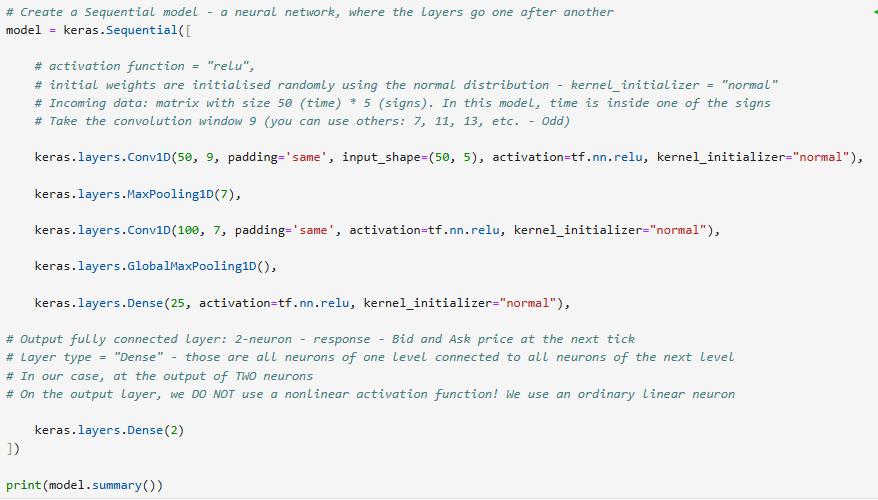

In [35]:
model = keras.Sequential([
    keras.layers.Conv1D(50, 9, padding='same', input_shape=(50, 5), activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.MaxPooling1D(7),
    keras.layers.Conv1D(100, 7, padding='same', activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(25, activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.Dense(2)
])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 50, 50)         │         2,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 100)         │        35,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,977 (156.16 KB)

 Trainable params: 39,977 (156.16 KB)

 Non-trainable params: 0 (0.00 B)

None


### Model compilation

________________________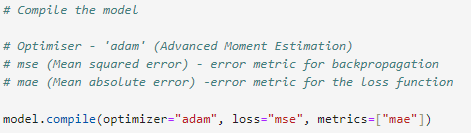

In [36]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
#model.fit?

### Trainig CNN

________________________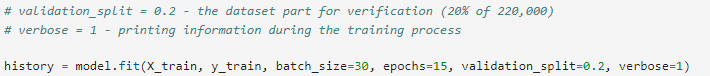

In [37]:
history = model.fit(X_train, y_train, batch_size=30, epochs=15, validation_split=0.2, verbose=1)

Epoch 1/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0017 - mae: 0.0245 - val_loss: 9.4443e-04 - val_mae: 0.0208
Epoch 2/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 7.5775e-04 - mae: 0.0188 - val_loss: 8.5570e-04 - val_mae: 0.0189
Epoch 3/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 7.3078e-04 - mae: 0.0183 - val_loss: 9.2736e-04 - val_mae: 0.0207
Epoch 4/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 7.2255e-04 - mae: 0.0182 - val_loss: 8.8029e-04 - val_mae: 0.0197
Epoch 5/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 7.1432e-04 - mae: 0.0180 - val_loss: 9.0954e-04 - val_mae: 0.0204
Epoch 6/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 7.0833e-04 - mae: 0.0179 - val_loss: 8.4341e-04 - val_mae: 0.0190
Epoch 7/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 7.0573e-04 - mae: 0.0178 - val_loss: 8.2997e-04 - val_mae: 0.0186
Epoch 8/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 7.0533e-04 - mae: 0.0178 - val_loss: 8

### Evaluation

__________________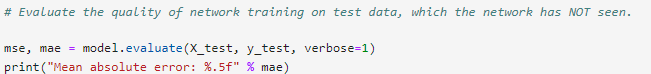

In [38]:
mse, mae = model.evaluate(X_test, y_test, verbose=1)
print("Mean absolute error: %.5f" % mae)

936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0538e-04 - mae: 0.0166
Mean absolute error: 0.01658


### Mean Absolute Error (MAE) graphs during training

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

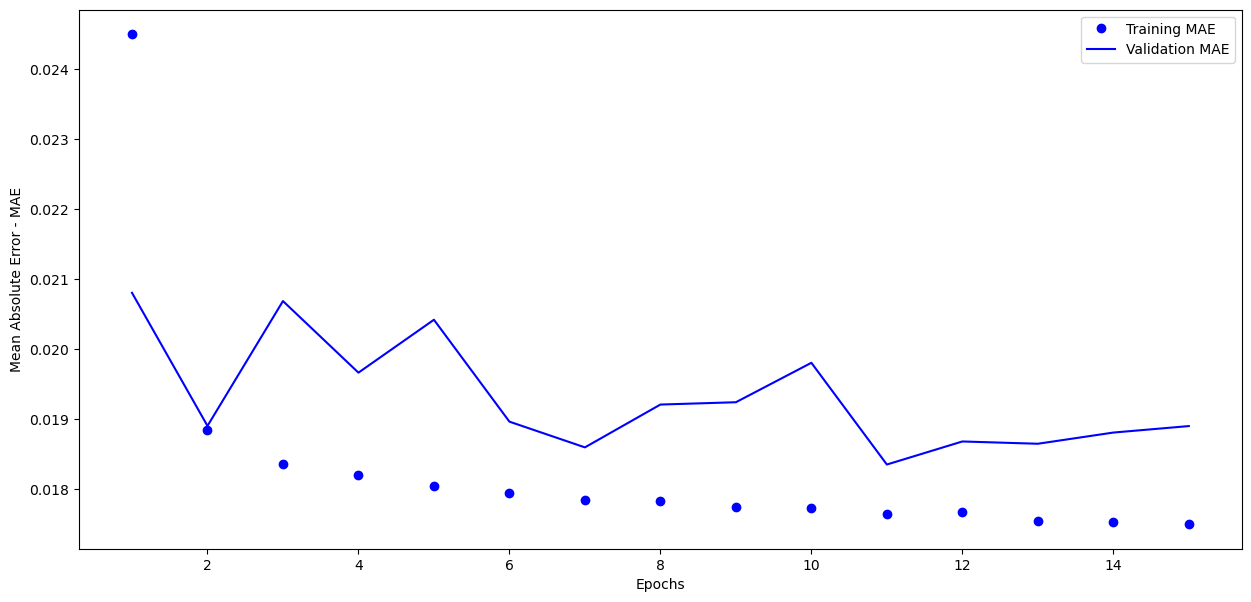

In [39]:
history_dict = history.history

mean_absolute_error_values = history_dict['mae']

val_mean_absolute_error_values = history_dict['val_mae']

epochs = range(1, len(mean_absolute_error_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mean_absolute_error_values, 'bo', label='Training MAE')
plt.plot(epochs, val_mean_absolute_error_values, 'b', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error - MAE')
plt.legend()
plt.show()

### Normalised Price Chart

In [40]:
pred = model.predict(X_test)

936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


____________________________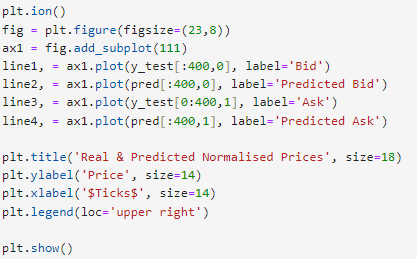

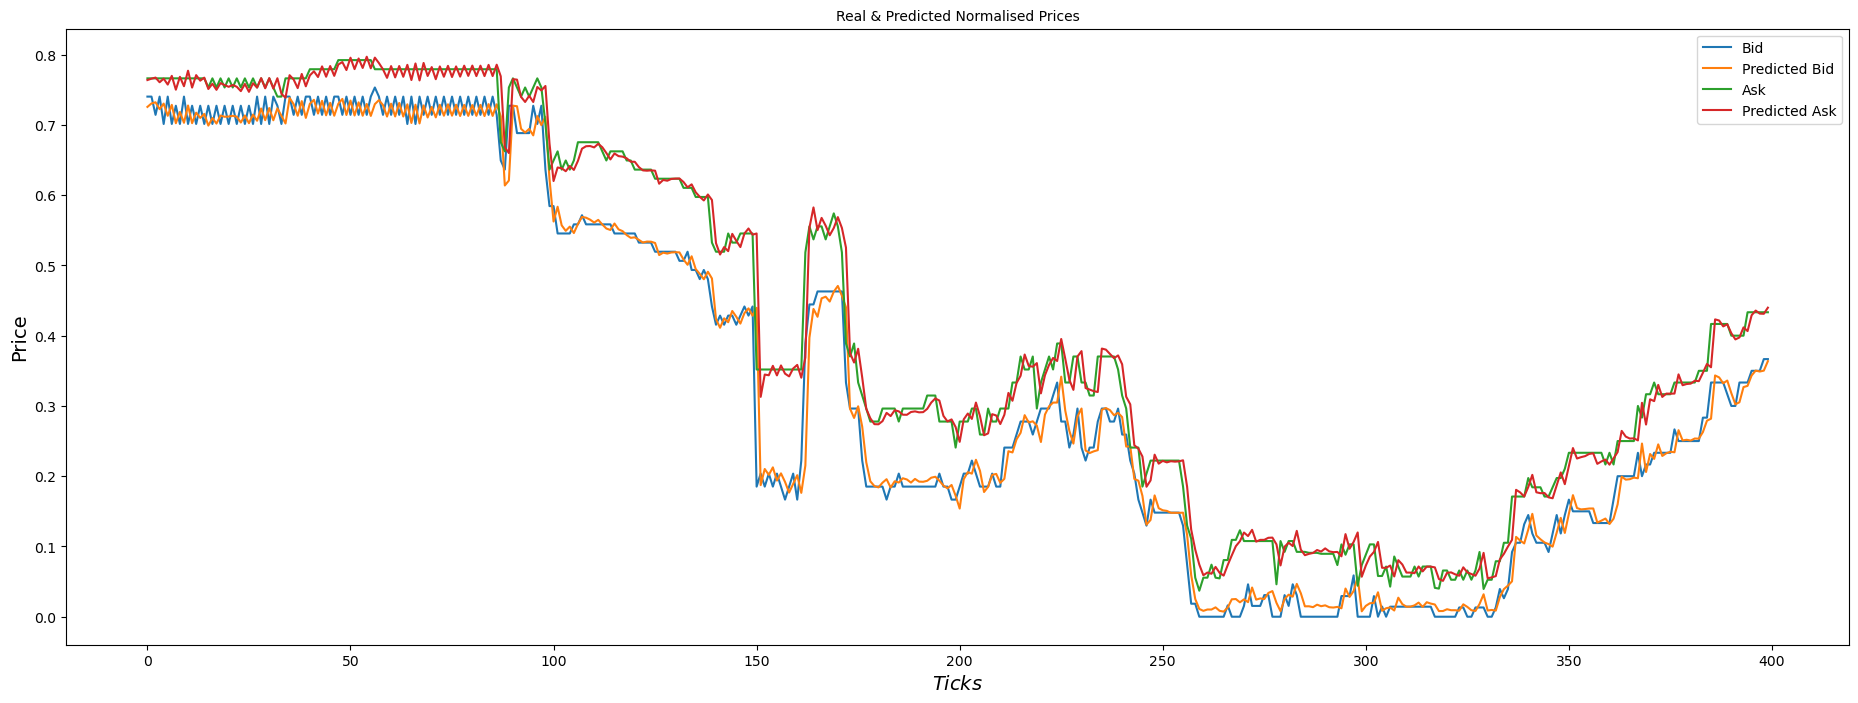

In [41]:
plt.ion()
fig = plt.figure(figsize=(23,8))
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test[:400,0], label='Bid')
line2, = ax1.plot(pred[:400,0], label='Predicted Bid')
line3, = ax1.plot(y_test[0:400,1], label='Ask')
line4, = ax1.plot(pred[:400,1], label='Predicted Ask')

plt.title('Real & Predicted Normalised Prices', size=10)
plt.ylabel('Price', size=14)
plt.xlabel('$Ticks$', size=14)
plt.legend(loc='upper right')

plt.show()

### Detailed Error Chart

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

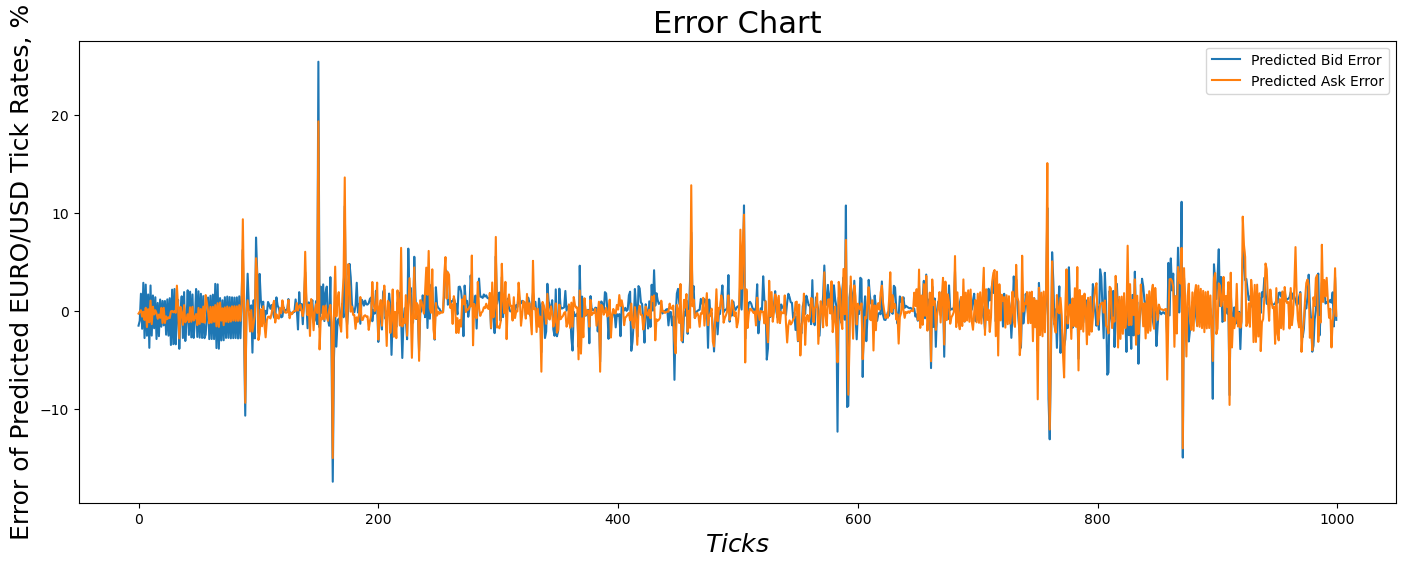

In [42]:
N1=0     # start
N2=1000   # end

plt.ion()
fig = plt.figure(figsize=(17,6))
ax1 = fig.add_subplot(111)

a = (pred[N1:N2,0]-y_test[N1:N2,0])*100
b = (pred[N1:N2,1]-y_test[N1:N2,1])*100

line1, = ax1.plot(a, label='Predicted Bid Error')
line2, = ax1.plot(b, label='Predicted Ask Error')

plt.title('Error Chart', size=22)
plt.ylabel('Error of Predicted EURO/USD Tick Rates, %', size=18)
plt.xlabel('$Ticks$', size=18)
plt.legend(loc='upper right') 

plt.show()

In [ ]:
# explain the results by writing a few sentences

In [ ]:
The model is mostly accurate to within around 5 percent of the real value, but experiences occasional miscalculations that result in
an error of 10 to 15 percent. Additionally, there is one outlier at around 150 ticks where the model's prediction is highly inaccurate -
this is caused by a sudden fluctuation in price that the model was not able to fully predict.

# Lab Logbook Requirement:

<html> <h3 style="font-style:italic; color:blue;">
   
1) Modify the practical session CNN model by reducing the convolutional core size to 5.
2) Change the batch_size to 50.
3) Also, change the number of epochs, which is calculated by the formula:

   Z + Y, if Z and Y are not 0

   10 + Y, if Z = 0 and Y is not 0

   10, if Z = Y = 0

   , where your SID is: XXXXXZY
5) Leave other parameters the same as in the practical session.
6) Compile the model.
6) Train your CNN with the same datasets and demonstrate the received test MAE.
Compare your MAE with the MAE of the CNN in the practical session.
7) Please only add to your Lab Logbook print-screen(s) of your CNN architecture using model.summary(), CNN training code and process,  and the resulting MAE.
    
</h3> </html>

<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK, AND UPLOAD THE LAB LOGBOOK REQUIREMENTS AS A SCREENSHOT OF YOUR CODE AND RESULT(S) ON YOUR GITHUB.
</h3> </html>

In [46]:
##Create model
lModel = keras.Sequential([
    keras.layers.Conv1D(50, 9, padding='same', input_shape=(50, 5), activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.MaxPooling1D(5),
    keras.layers.Conv1D(100, 5, padding='same', activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(25, activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.Dense(2)
])

print(lModel.summary())

lModel.compile(optimizer="adam", loss="mse", metrics=["mae"])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 50, 50)         │         2,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 10, 100)        │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,977 (117.10 KB)

 Trainable params: 29,977 (117.10 KB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
lHistory = lModel.fit(X_train, y_train, batch_size=50, epochs=18, validation_split=0.2, verbose=1)

Epoch 1/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0020 - mae: 0.0252 - val_loss: 8.8314e-04 - val_mae: 0.0194
Epoch 2/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.3380e-04 - mae: 0.0184 - val_loss: 0.0012 - val_mae: 0.0245
Epoch 3/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7.1306e-04 - mae: 0.0180 - val_loss: 8.9919e-04 - val_mae: 0.0201
Epoch 4/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 7.0570e-04 - mae: 0.0178 - val_loss: 8.3322e-04 - val_mae: 0.0187
Epoch 5/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 6.9737e-04 - mae: 0.0177 - val_loss: 8.2500e-04 - val_mae: 0.0185
Epoch 6/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 6.9120e-04 - mae: 0.0176 - val_loss: 8.2621e-04 - val_mae: 0.0185
Epoch 7/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.9011e-04 - mae: 0.0175 - val_loss: 8.3360e-04 - val_mae: 0.0186
Epoch 8/18
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.8970e-04 - mae: 0.0175 - val_loss: 8.319

In [48]:
lMse, lMae = lModel.evaluate(X_test, y_test, verbose=1)
print("Original mean absolute error: %.5f" % mae)
print("New model mean absolute error: %.5f" % lMae)

936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0725e-04 - mae: 0.0166
Original mean absolute error: 0.01658
New model mean absolute error: 0.01662
